In [ ]:
from keras.preprocessing.image import img_to_array,load_img
import numpy as np
import glob
import os 
import cv2
from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imutils

In [ ]:
from pathlib import Path 
store_image=[]
train_path=Path('/content/drive/MyDrive/UCSDped1/Train/')
train_images_dict = {
    'train': list(train_path.glob('*/*'))
}
for name,images in train_images_dict.items():
    for image in images:
      image_path = str(image)
      image=cv2.imread(image_path)
      try:
        image=cv2.resize(image, (227,227), interpolation = cv2.INTER_AREA)
        gray=0.2989*image[:,:,0]+0.5870*image[:,:,1]+0.1140*image[:,:,2]
        store_image.append(gray)
      except:
        continue  

In [ ]:
store_image=np.array(store_image)
a,b,c=store_image.shape
store_image.resize(b,c,a)
store_image=(store_image-store_image.mean())/(store_image.std())
store_image=np.clip(store_image,0,1)
np.save('training.npy',store_image)

In [ ]:
stae_model=Sequential()

stae_model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1),activation='tanh'))
stae_model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
stae_model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))
stae_model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))
stae_model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))
stae_model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
stae_model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',activation='tanh'))

stae_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [ ]:
training_data=np.load('training.npy')
frames=training_data.shape[2]
frames=frames-frames%10

In [ ]:
training_data=training_data[:,:,:frames]
training_data=training_data.reshape(-1,227,227,10)
training_data=np.expand_dims(training_data,axis=4)
target_data=training_data.copy()

In [ ]:
target_data[:1].shape

(1, 227, 227, 10, 1)

In [ ]:
epochs=2
batch_size=1

callback_save = ModelCheckpoint("saved_model.h5", monitor="mean_squared_error", save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
stae_model.fit(training_data[3:10],target_data[3:10], batch_size=batch_size, epochs=epochs, callbacks = [callback_save,callback_early_stopping])
stae_model.save("saved_model.h5")

Epoch 1/2
4/4 [==============================] - 12s 1s/step - loss: 0.2058 - accuracy: 0.5951
Epoch 2/2
4/4 [==============================] - 4s 970ms/step - loss: 0.2031 - accuracy: 0.5951


#TEST

In [ ]:
import argparse
from PIL import Image
from keras.models import load_model
import cv2
import  imutils

In [ ]:
def mean_squared_loss(x1,x2):
    difference=x1-x2
    a,b,c,d,e=difference.shape
    n_samples=a*b*c*d*e
    sq_difference=difference**2
    Sum=sq_difference.sum()
    distance=np.sqrt(Sum)
    mean_distance=distance/n_samples
    return mean_distance

In [ ]:
model=load_model("saved_model.h5")

In [ ]:
cap = cv2.VideoCapture("/content/project.avi")
print(cap.isOpened())

True


In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np 

Abnormal Event Detected


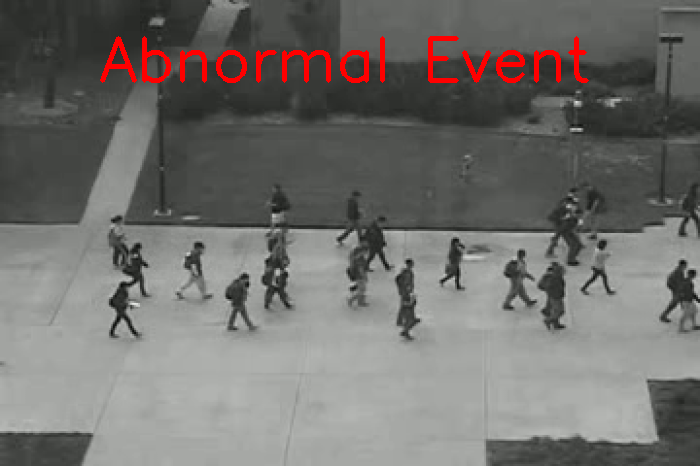

Abnormal Event Detected


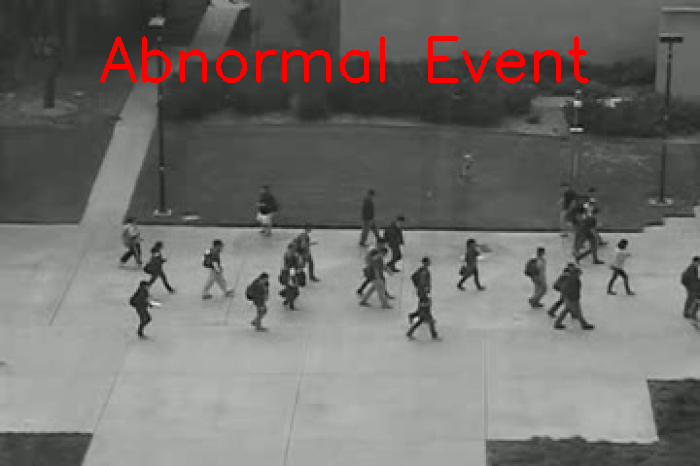

Abnormal Event Detected


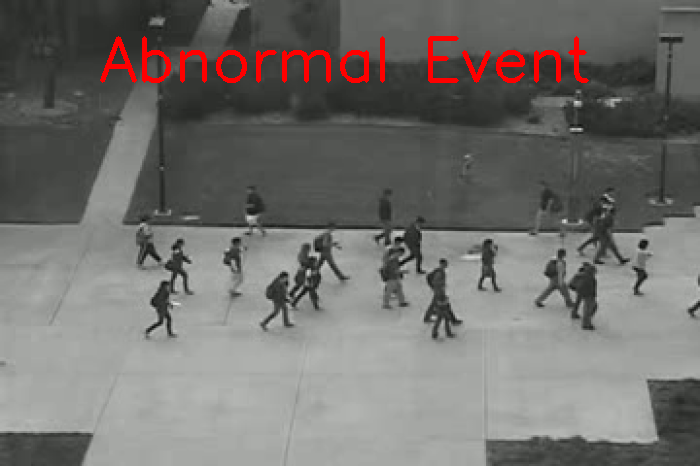

Abnormal Event Detected


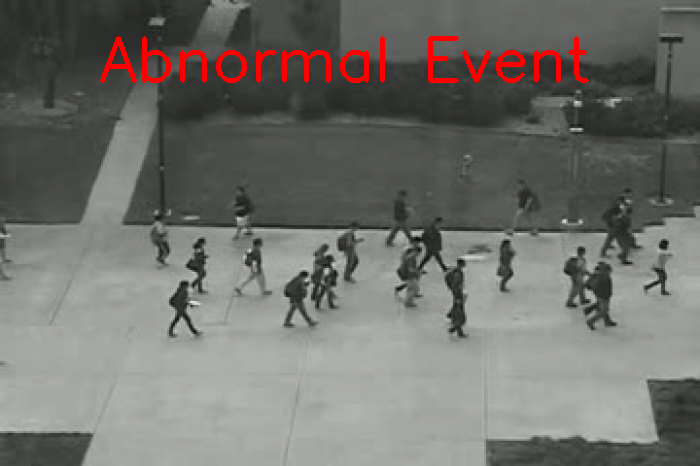

Abnormal Event Detected


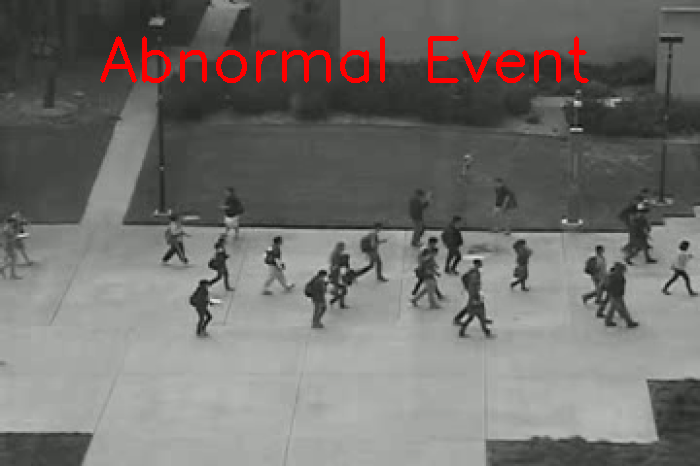

Abnormal Event Detected


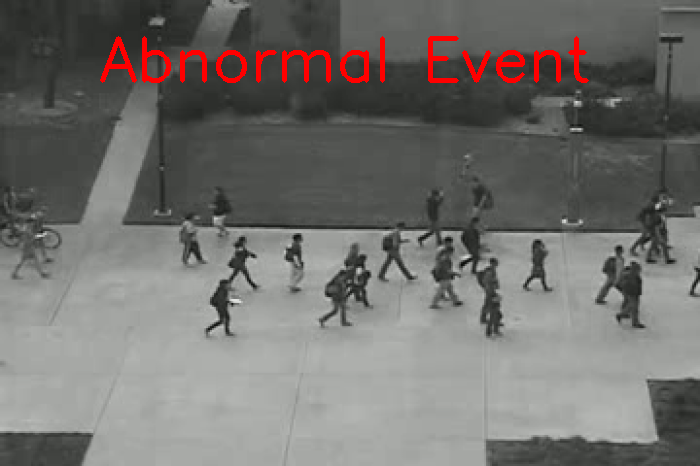

Abnormal Event Detected


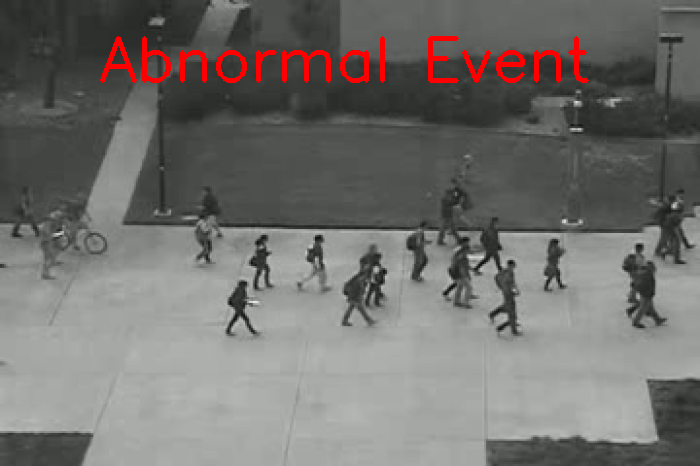

Abnormal Event Detected


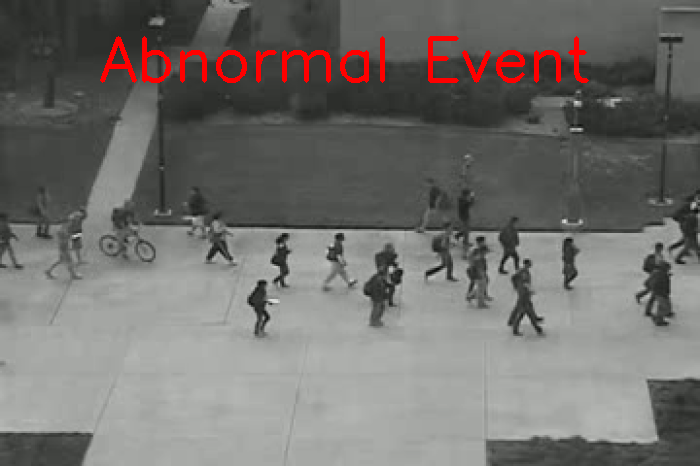

Abnormal Event Detected


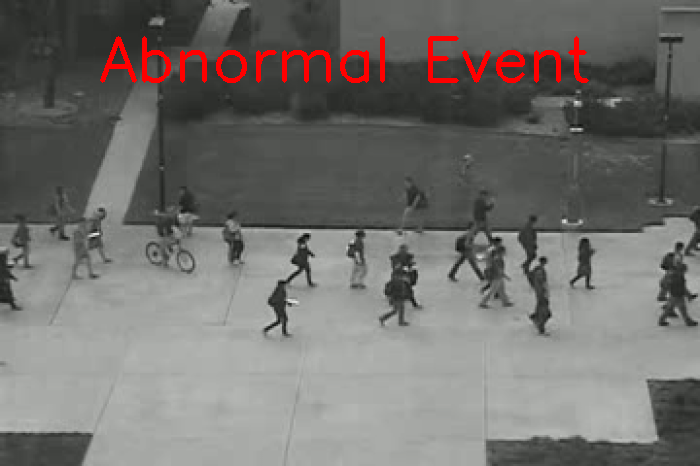

Abnormal Event Detected


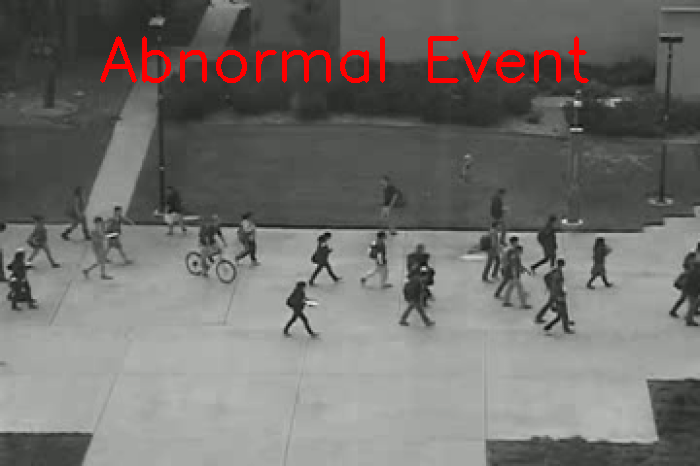

Abnormal Event Detected


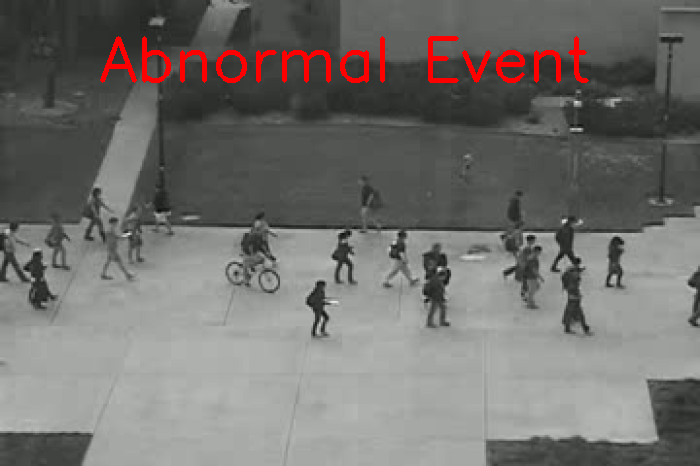

Abnormal Event Detected


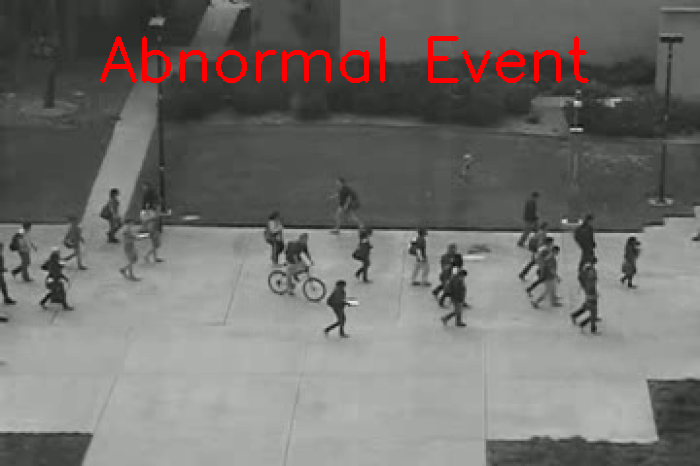

Abnormal Event Detected


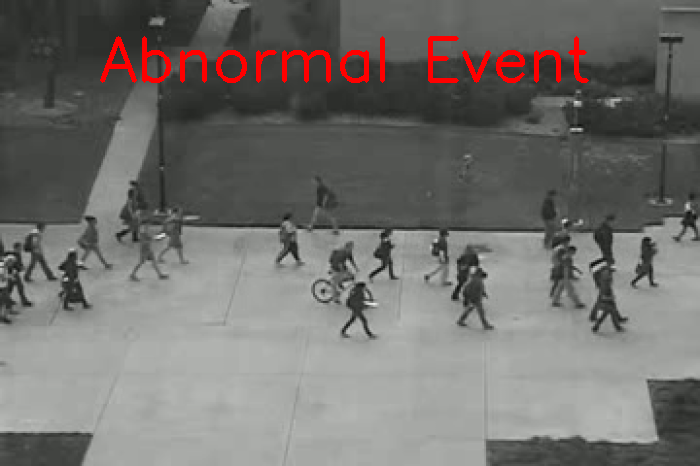

Abnormal Event Detected


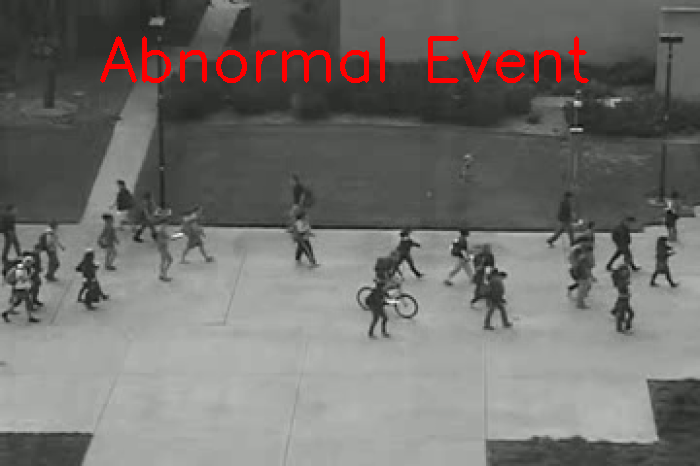

Abnormal Event Detected


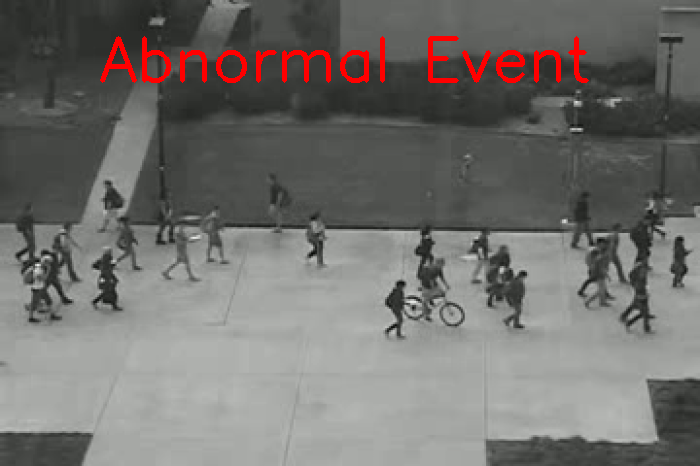

Abnormal Event Detected


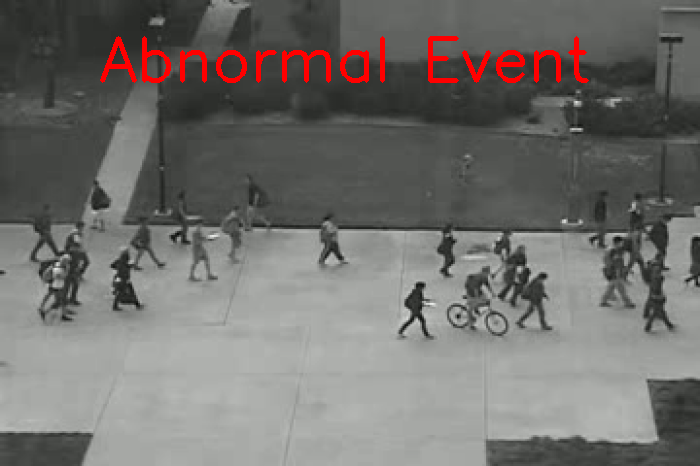

AttributeError: ignored

In [ ]:
while cap.isOpened():
    imagedump=[]
    ret,frame=cap.read()
    for i in range(10):
        ret,frame=cap.read()
        image = imutils.resize(frame,width=700,height=600)
        frame=cv2.resize(frame, (227,227), interpolation = cv2.INTER_AREA)
        gray=0.2989*frame[:,:,0]+0.5870*frame[:,:,1]+0.1140*frame[:,:,2]
        gray=(gray-gray.mean())/gray.std()
        gray=np.clip(gray,0,1)
        imagedump.append(gray)
    imagedump=np.array(imagedump)
    imagedump.resize(227,227,10)
    imagedump=np.expand_dims(imagedump,axis=0)
    imagedump=np.expand_dims(imagedump,axis=4)
    output=model.predict(imagedump)
    loss=mean_squared_loss(imagedump,output)
    if frame.any()==None:
        print("none")
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
    if loss>0.00067:
        print('Abnormal Event Detected')
        cv2.putText(image,"Abnormal Event",(100,80),cv2.FONT_HERSHEY_SIMPLEX,2,(0,0,255),4)
    cv2_imshow(image)
cap.release()
cv2.destroyAllWindows()